In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [82]:

df = pd.read_csv("cleaned_churn_data.csv")

df.tail(15)

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio
7028,7029,68,1,3,Bank transfer (automatic),64.10,4326.25,0,0.942647
7029,7030,6,0,0,Electronic check,44.40,263.05,0,7.400000
7030,7031,2,1,0,Mailed check,20.05,39.25,0,10.025000
7031,7032,55,1,1,Credit card (automatic),60.00,3316.10,0,1.090909
7032,7033,1,1,0,Electronic check,75.75,75.75,1,75.750000
7033,7034,38,1,0,Credit card (automatic),69.50,2625.25,0,1.828947
7034,7035,67,1,0,Credit card (automatic),102.95,6886.25,1,1.536567
7035,7036,19,1,0,Bank transfer (automatic),78.70,1495.10,0,4.142105
7036,7037,12,0,1,Electronic check,60.65,743.30,0,5.054167
7037,7038,72,1,3,Bank transfer (automatic),21.15,1419.40,0,0.293750


## Further prepping the data

In [83]:
# Drop customerID - not useful for modeling
df = df.drop('customerID', axis=1)
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio
0,1,0,0,Electronic check,29.85,29.85,0,29.850000
1,34,1,1,Mailed check,56.95,1889.50,0,1.675000
2,2,1,0,Mailed check,53.85,108.15,1,26.925000
3,45,0,1,Bank transfer (automatic),42.30,1840.75,0,0.940000
4,2,1,0,Electronic check,70.70,151.65,1,35.350000
...,...,...,...,...,...,...,...,...
7038,24,1,1,Mailed check,84.80,1990.50,0,3.533333
7039,72,1,1,Credit card (automatic),103.20,7362.90,0,1.433333
7040,11,0,0,Electronic check,29.60,346.45,0,2.690909
7041,4,1,0,Mailed check,74.40,306.60,1,18.600000


## Generate dummies and convert to numeric

In [84]:
payment_method_dummies = pd.get_dummies(df['PaymentMethod'])
df = pd.concat([df, payment_method_dummies], axis=1)
df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,1,0,0,Electronic check,29.85,29.85,0,29.850,False,False,True,False
1,34,1,1,Mailed check,56.95,1889.50,0,1.675,False,False,False,True
2,2,1,0,Mailed check,53.85,108.15,1,26.925,False,False,False,True
3,45,0,1,Bank transfer (automatic),42.30,1840.75,0,0.940,True,False,False,False
4,2,1,0,Electronic check,70.70,151.65,1,35.350,False,False,True,False


In [85]:
dummies = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']

for column in dummies:
    df[column] = pd.factorize(df[column])[0]

df.sample(5)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
5868,1,1,0,Mailed check,44.00,44.00,0,44.00000,0,0,1,1
6068,12,1,0,Electronic check,44.55,480.60,1,3.71250,0,0,0,0
792,8,1,3,Mailed check,19.85,146.60,0,2.48125,0,0,1,1
1069,20,1,1,Mailed check,54.00,1055.90,0,2.70000,0,0,1,1
2510,1,1,0,Mailed check,74.25,74.25,1,74.25000,0,0,1,1


In [86]:
df = df.drop('PaymentMethod', axis=1)
df

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,1,0,0,29.85,29.85,0,29.850000,0,0,0,0
1,34,1,1,56.95,1889.50,0,1.675000,0,0,1,1
2,2,1,0,53.85,108.15,1,26.925000,0,0,1,1
3,45,0,1,42.30,1840.75,0,0.940000,1,0,1,0
4,2,1,0,70.70,151.65,1,35.350000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1,1,84.80,1990.50,0,3.533333,0,0,1,1
7039,72,1,1,103.20,7362.90,0,1.433333,0,1,1,0
7040,11,0,0,29.60,346.45,0,2.690909,0,0,0,0
7041,4,1,0,74.40,306.60,1,18.600000,0,0,1,1


In [87]:
df.isna().sum()

tenure                            0
PhoneService                      0
Contract                          0
MonthlyCharges                    0
TotalCharges                      0
Churn                             0
MonthlyCharges_to_tenure_Ratio    0
Bank transfer (automatic)         0
Credit card (automatic)           0
Electronic check                  0
Mailed check                      0
dtype: int64

## Remove outliers

In [92]:

numerical_columns = df.select_dtypes(include=[np.number]).columns

# Function to remove outliers based on IQR
def remove_outliers_iqr(data_frame, columns):
    for column in columns:
        Q1 = data_frame[column].quantile(0.25)
        Q3 = data_frame[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_frame = data_frame[(data_frame[column] >= lower_bound) & (data_frame[column] <= upper_bound)]
    return data_frame

df_clean = remove_outliers_iqr(df, numerical_columns)
df_clean

,tenure,PhoneService,Contract,MonthlyCharges,TotalCharges,Churn,MonthlyCharges_to_tenure_Ratio,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
1,34,1,1,56.95,1889.50,0,1.675000,0,0,1,1
5,8,1,0,99.65,820.50,1,12.456250,0,0,0,0
8,28,1,0,104.80,3046.05,1,3.742857,0,0,0,0
10,13,1,0,49.95,587.45,0,3.842308,0,0,1,1
14,25,1,0,105.50,2686.05,0,4.220000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7023,63,1,0,103.50,6479.40,0,1.642857,0,0,0,0
7027,13,1,0,73.35,931.55,0,5.642308,0,0,1,1
7030,2,1,0,20.05,39.25,0,10.025000,0,0,1,1
7038,24,1,1,84.80,1990.50,0,3.533333,0,0,1,1


## Modelling

## Split data into features (X) and target (y)

In [93]:
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

## Split data into training and testing sets

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Model

In [96]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [103]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7155599603567889
0.699009900990099


The accuracy score on the training set is 0.715 while the accuracy score on the test set is approximately 0.70, indicating that the model performs less accurately on test data compared to the training data.

## Predictions on the test set

In [99]:
y_pred = model.predict(X_test)


## Model Evaluation

In [100]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report

## Display Evaluation metrics

In [101]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print('Classification Report:\n', classification_report_str)

Accuracy: 0.70
Confusion Matrix:
[[280  59]
 [ 93  73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       339
           1       0.55      0.44      0.49       166

    accuracy                           0.70       505
   macro avg       0.65      0.63      0.64       505
weighted avg       0.69      0.70      0.69       505



## Plot Confusion Matrix

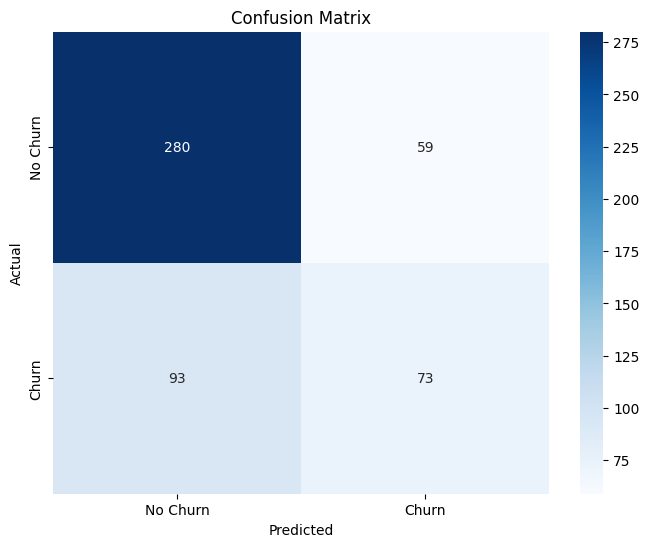

In [102]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Evaluation Metrics
Accuracy: 0.80 

**Confusion Matrix**
[[280 59]
 [93 73]]

**Classification Report**
```shell 
	precision	 recall     f1-score   support

0       0.75      0.83      0.79       339
1       0.55      0.44      0.49       166

accuracy                           0.70       505
macro avg       0.65      0.63      0.64       505
weighted avg    0.69      0.70      0.69       505
```

**Interpretation**

Accuracy - The model achieved an accuracy of 70%, which represents the overall correct predictions out of the total predictions.

Confusion Matrix - The confusion matrix provides a detailed breakdown of the model's predictions
    True Negatives (TN) for class 0 (non-churn): 280

    True Positives (TP) for class 1 (churn): 73
    False Positives (FP): 59 (Predicted as non-churn but actually churn)
    False Negatives (FN): 93 (Predicted as churn but actually non-churn)

**Classification Report**

Precision (class 0): 0.75 - 75% of the predicted non-churn cases were correct.

Recall (class 0): 0.83 - Out of all actual non-churn cases, the model identified 83% of them.

F1-score (class 0): 0.79 - A balanced measure considering both precision and recall for non-churn class.

Precision (class 1): 0.55 - 55% of the predicted churn cases were correct.

Recall (class 1): 0.44 - Out of all actual churn cases, the model identified 44% of them.

F1-score (class 1): 0.49 - A balanced measure considering both precision and recall for the churn class.



## Comparing with No Information rate

In [104]:

no_info_rate = max(y_train.value_counts(normalize=True))
print(f'No Information Rate: {no_info_rate}')

No Information Rate: 0.6600594648166501


**No-Information Rate (0.661)**

This rate serves as a baseline metric, indicating the accuracy achieved by always predicting the majority class (i.e., No churn).

## Model Tuning

In [105]:
model.predict_proba(X_test)

array([[0.71908946, 0.28091054],
       [0.34413801, 0.65586199],
       [0.46951558, 0.53048442],
       ...,
       [0.85176435, 0.14823565],
       [0.22340356, 0.77659644],
       [0.55117707, 0.44882293]])

In [106]:
model.predict(X_test)[:15]

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

The result is an array of binary values (0 or 1), where each value represents the predicted class for a specific instance in the test set. For binary classification problems like predicting churn (1 or 0), 0 typically represents one class - no churn - and 1 represents the other class - churn.

In [108]:
(model.predict_proba(X_test)[:10, 1] > 0.3).astype('int')

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1])

Here we generate a boolean array indicating whether the predicted probability of class 1 (positive class) for each sample in the first 10 rows of the test set is greater than 0.3. The .astype('int') method then converts these boolean values to integers, where True becomes 1 and False becomes 0.

So, the resulting array [0, 1, 1, 0, 0, 0, 1, 0, 0, 1] corresponds to the binary predictions (0 or 1) for the first 10 samples in the test set based on the threshold of 0.3. A value of 1 indicates that the predicted probability of belonging to class 1 is greater than 0.3, while a value of 0 indicates that it is not.

## Lowering the threshold further

In [111]:
predictions_lt = (model.predict_proba(X_test)[:10, 1] > 0.15).astype('int')
predictions_lt

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

The resulting array predictions_lt is a binary classification where instances are classified as 1 if the predicted probability of belonging to class 1 is greater than 0.15 and 0 otherwise.

## Checking accuracy and TP rate

In [115]:
predictions_lt = (model.predict_proba(X_test)[:, 1] > 0.15).astype('int')
print(accuracy_score(y_test, predictions_lt))


0.5267326732673268


The accuracy score of approximately 69.01% signifies the overall proportion of correct predictions made by the model on the test set. Specifically, it indicates that:

Out of all the samples in the test set, approximately 52.67% of them were correctly classified by the model.

The model's predictions matched the true labels for approximately 52.67% of the samples in the test set.

In [116]:
tn, fp, fn, tp  = confusion_matrix(y_test, predictions_lt).flatten()
print(tp / (tp + fn))

0.9397590361445783


The true positive rate (TPR), also known as sensitivity or recall, for a binary classification model is calculated.

tp represents the number of true positives (correctly predicted positive instances).

fn represents the number of false negatives (actual positive instances incorrectly predicted as negative).

The formula (tp / (tp + fn)) calculates the true positive rate, which is the ratio of correctly predicted positive instances to the total actual positive instances.

The true positive rate is approximately 0.9398, indicating that the model correctly predicted around 93.98% of the positive instances in the test set.

In [117]:
model.coef_

array([[-0.71385862,  0.        , -0.43216271,  0.73702122,  0.40493986,
         0.34830072,  0.        ,  0.        , -0.11543474, -0.11543474]])

<Axes: >

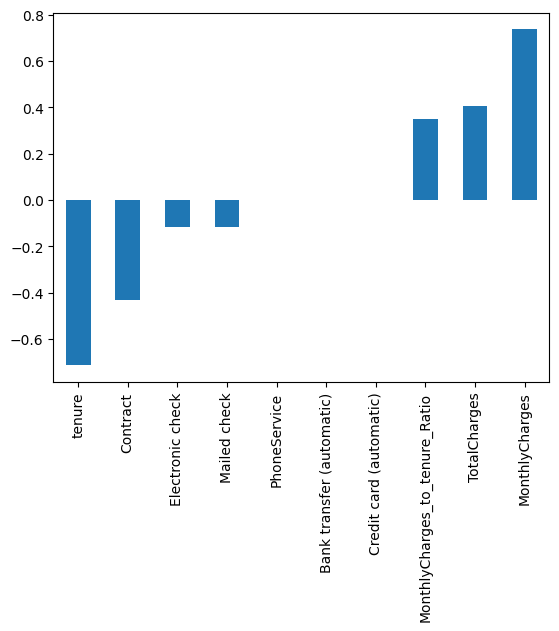

In [118]:
coef_df = pd.DataFrame(data=model.coef_, columns=X.columns)

coef_df.T.sort_values(by=0).plot.bar(legend=False)


**Plot Interpretation**

The plot visualizes the coefficients for each feature in a bar chart format.

Features with positive coefficients are represented by bars pointing upwards, while features with negative coefficients are represented by bars pointing downwards.

The length of each bar indicates the magnitude of the coefficient, representing the strength of the association with the target variable.

Features with longer bars (either positive or negative) such as MonthlyCharges and tenure have a stronger influence on the model's predictions.

Those with positive coefficients - MonthlyCharges and TotalCharges - have a positive impact on the likelihood of churn, while features with negative coefficients (downward bars) have a negative impact.

The plot provides insights into which features are most influential in predicting churn, allowing stakeholders to prioritize and focus on key factors affecting customer churn.

The coefficients and the plot help in understanding the relative importance of different features in predicting churn, guiding decision-making processes aimed at reducing churn rates and improving customer retention strategies.

## Other ML Models

## Split data into training and testing sets

## Use K nearest Neighbours

In [137]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [138]:
print(knn_model.score(X_train, y_train))
print(knn_model.score(X_test, y_test))


0.7898909811694748
0.6712871287128713


In [126]:
# Evaluate KNN model
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"Accuracy of KNN: {accuracy_knn}")

Accuracy of KNN: 0.6712871287128713


## Using support vector classifier model

In [127]:
svc_model = SVC(kernel='linear', C=1)
svc_model.fit(X_train, y_train)



SVC(C=1, kernel='linear')

In [128]:
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_test, y_test))


0.7175421209117938
0.699009900990099


In [135]:
# Evaluate SVC model
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print(f"Accuracy of SVC: {accuracy_svc}")


Accuracy of SVC: 0.699009900990099


The accuracy scores for the K-Nearest Neighbors (KNN) and Support Vector Classifier (SVC) models on the training and test sets are as follows:

For KNN:

    Training Accuracy: 78.99%
    Test Accuracy: 67.13%

For SVC:

    Training Accuracy: 71.75%
    Test Accuracy: 69.90%

## Confusion Matrix

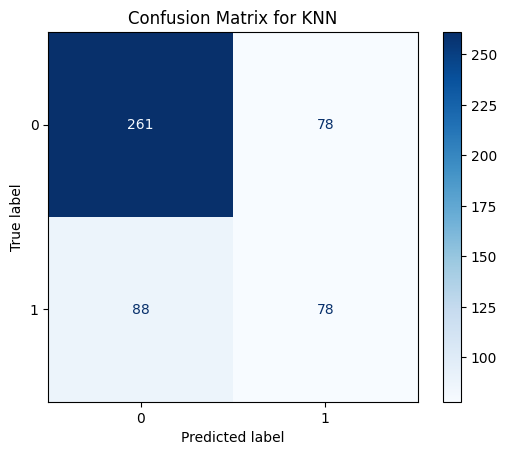

In [133]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn_model.classes_)
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.show()


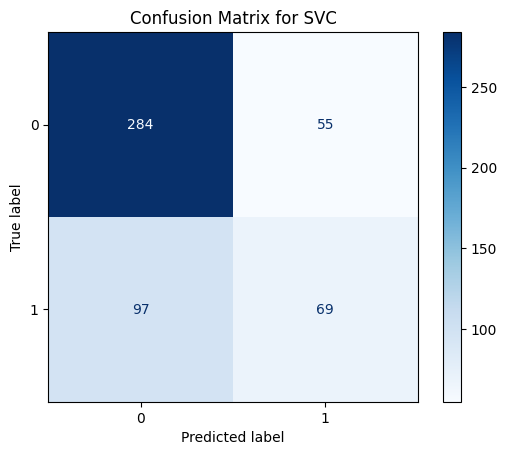

In [136]:
# Confusion Matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc_model.classes_)
disp_svc.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVC")
plt.show()

In [141]:
# Logistic Regression
logistic_params = {'max_iter': [2000, 4000, 6000]}
logistic_model = LogisticRegression()
logistic_grid = GridSearchCV(logistic_model, param_grid=logistic_params, cv=3, scoring='accuracy')
logistic_grid.fit(X_train, y_train)

# K-Nearest Neighbors (KNN)
knn_params = {'n_neighbors': [3, 5, 7], 'p': [1, 2]}
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, param_grid=knn_params, cv=3, scoring='accuracy')
knn_grid.fit(X_train, y_train)

# Support Vector Classifier (SVC)
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svc_model = SVC(probability=True)
svc_grid = GridSearchCV(svc_model, param_grid=svc_params, cv=3, scoring='accuracy')
svc_grid.fit(X_train, y_train)

# Calculate test accuracies
logistic_accuracy = accuracy_score(y_test, logistic_grid.predict(X_test))
knn_accuracy = accuracy_score(y_test, knn_grid.predict(X_test))
svc_accuracy = accuracy_score(y_test, svc_grid.predict(X_test))

# Display best parameters and accuracy for each model
print("Logistic Regression - Best Parameters:", logistic_grid.best_params_)
print("Logistic Regression - Test Accuracy:", logistic_accuracy)

print("K-Nearest Neighbors - Best Parameters:", knn_grid.best_params_)
print("K-Nearest Neighbors - Test Accuracy:", knn_accuracy)

print("Support Vector Classifier - Best Parameters:", svc_grid.best_params_)
print("Support Vector Classifier - Test Accuracy:", svc_accuracy)



Logistic Regression - Best Parameters: {'max_iter': 2000}
Logistic Regression - Test Accuracy: 0.699009900990099
K-Nearest Neighbors - Best Parameters: {'n_neighbors': 7, 'p': 1}
K-Nearest Neighbors - Test Accuracy: 0.691089108910891
Support Vector Classifier - Best Parameters: {'C': 1, 'kernel': 'rbf'}
Support Vector Classifier - Test Accuracy: 0.7128712871287128


The output provides information about the best hyperparameters selected by the grid search and the corresponding test accuracy for each model:

**Logistic Regression**

Best Parameters: {'max_iter': 2000}
Test Accuracy: 0.699

The logistic regression model achieved the best results with a maximum iteration of 2000. The test accuracy is 0.699, meaning the model correctly predicted the target variable in approximately 69.9% of the test samples.

**K-Nearest Neighbors**

Best Parameters: {'n_neighbors': 7, 'p': 1}
Test Accuracy: 0.691

The K-Nearest Neighbors model performed optimally with 7 neighbors and using the Manhattan distance metric (p=1). The test accuracy is 0.691, indicating that the model correctly classified around 69.1% of the test instances.

**Support Vector Classifier**

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Test Accuracy: 0.713

The Support Vector Classifier achieved the best results with a regularization parameter (C) of 1 and a radial basis function (RBF) kernel. The test accuracy is 0.713, indicating that the model correctly predicted the target variable in approximately 71.3% of the test samples.

## Determining the best model

In [142]:
model_accuracies = {
    'Logistic Regression': logistic_accuracy,
    'K-Nearest Neighbors': knn_accuracy,
    'Support Vector Classifier': svc_accuracy
}

best_model = max(model_accuracies, key=model_accuracies.get)

print(f"The best model is: {best_model} with test accuracy {model_accuracies[best_model]:.3f}")


The best model is: Support Vector Classifier with test accuracy 0.713


Support Vector Classifier performed the best among the models you evaluated, achieving a test accuracy of 0.713.

In [145]:
svc_grid.best_estimator_

SVC(C=1, probability=True)

In [146]:
print(classification_report(y_test, svc_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       339
           1       0.58      0.45      0.51       166

    accuracy                           0.71       505
   macro avg       0.67      0.64      0.65       505
weighted avg       0.70      0.71      0.70       505



The classification report provides various metrics for each class, including precision, recall, and F1-score. 

Precision: The precision for a class is the ratio of correctly predicted positive observations to the total predicted positives for that class. 

For class 0 (Churn = 0), precision is 0.76. This means that out of all instances predicted as class 0, 76% were actually class 0.

For class 1 (Churn = 1), precision is 0.58. This means that out of all instances predicted as class 1, 58% were actually class 1.

Recall: The recall for a class is the ratio of correctly predicted positive observations to the total actual positives for that class. In the report:

For class 0, recall is 0.84 meaning that out of all actual instances of class 0, 84% were correctly predicted as class 0.

For class 1, recall is 0.45 meaning out of all actual instances of class 1, 45% were correctly predicted as class 1.

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. It is calculated as 2 * (precision * recall) / (precision + recall).

        For class 0, the F1-score is 0.80.
        For class 1, the F1-score is 0.51.

Support: The number of actual occurrences of the class in the specified dataset. In this case, the support for class 0 is 339, and for class 1 is 166.

Accuracy: Overall accuracy of the model on the test set, calculated as (TP + TN) / (TP + TN + FP + FN). In this case, the overall accuracy is 0.71, meaning 71% of instances were correctly classified.

Macro Avg and Weighted Avg: These are the averages of the metrics (precision, recall, F1-score) across all classes. Macro Avg treats all classes equally, while Weighted Avg considers the number of instances for each class.

## ROC Curve

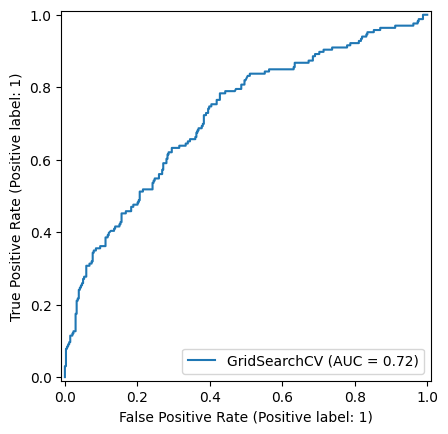

In [147]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(svc_grid, X_test, y_test)
plt.show()

## Summary

Throughout this analysis, we began by loading a dataset focused on predicting customer churn. We handled missing values and transformed categorical variables to prepare the data for modeling. Exploring the dataset's features and statistics allowed us to gain insights into its structure. Subsequently, we built machine learning models, including logistic regression, knn, and svc, training them to predict customer churn. 

Model performance was assessed using metrics such as accuracy and confusion matrices. To optimize these models, we employed grid search to tune hyperparameters. After comparing model performances, the best-performing model, determined based on test accuracy, was selected.
 
Feature importance analysis was conducted to understand the contribution of different variables. 

Alternative models like K-Nearest Neighbors (KNN) and Support Vector Classifier (SVC) were explored. Grid search was performed to fine-tune hyperparameters for these models, leading to the determination of the best model based on test accuracy. A classification report for the best model provided a comprehensive overview of precision, recall, F1-score, and support values for each class, offering valuable insights into the model's performance on the test set.

## Deployment

## Data Pipelines: Between the customer management system and the model


Deploying the Support Vector Classifier (SVC) model involves integrating it into existing data pipelines within the business infrastructure.
 
Firstly, relevant customer data should be collected from the customer management system, including demographics, transaction history, and interaction data. After data preprocessing, where missing values are handled, categorical variables are encoded, and numerical features are scaled, the trained SVC model is deployed. 

This can be achieved by containerizing the model as a microservice or deploying it on a cloud platform. Once deployed, data pipelines are established to facilitate the flow of data between the customer management system and the model. These pipelines ensure that incoming customer data is processed and forwarded to the model for prediction in real-time. The predictions generated by the model can then be used to support various business decisions, such as identifying customers at risk of churn, personalizing marketing campaigns, or recommending targeted interventions to improve customer retention. 

By integrating the model into the business workflow, the organization can leverage its predictive capabilities to gain valuable insights and drive informed decision-making processes.